# Analysis of Price-determinants of Airbnb Listings (Preprocessing and EDA)

Outline:
1. Business Perspective
2. Data Understanding
3. Data Preparation
4. Modelling
5. Discussion

### Business Perspective
The purpose of this notebook is to explore the determinants of listingprices of Airbnb's objects in Seattle and Boston. Intuitively, one might assume, that especially the size, the location and the accomodation type have a rather strong influence on the price. Furthermore, one might assume, that geh influence of amenities, heavily differ by the amennitiy in question. While some require the host to provide extra goods and services and can therefore be considered more expensive in their provision (e.g. air conditioning), others can be argued to pose additional inconvenience to the host without causing further provision cost. One example for such an amenitie would be the permission of young childrean during the stay. The accomodation of childrean, however, imply the the accomodation of an at least medium sized group, which in turn requires additional space and, therefore, a higher accommodation price. In this case a potentially higher price of family friendly accommodation would not be caused by the family friendliness itself, but by the additional spaces, correlated with it.

Considerations like this are the reason, this analyis aims to isolate each feature's influence on the price and provide an overview of the effect of each respective feature. It should be noted, however, that it would be beyond th escope of this project to proof any causal relationship between the features and the price. The results at teh end of the analysis can merely be indicative of causality.

In the last part of this analysis, this project goes in a different direction. Airbnb hosts provide (mostly) extensive descriptions of their objects. Unfortunately, these descriptions can sometimes be untrue or the host-guest relationship can be tainted for other reasons. Fortunately, repeated bad behaviour of hosts will soon mirror itself in the guests' reviews, which may cause potential guests to rather choose a different hosts. However, it can take several bad reviews, and therefore several unhappy guests and unfavourable customer experiences and maybe even official complaints and disputes until a the reviews reach a point, where a particular host becomes prohibited from hosting. Due to this consideration, the last part of this project will try and provide a text analysis model, which will aim at predicting the user experience from the textual descriptions only, and thus provide a early warning system.

#### Hypotheses
1. Features that are indicative (or related to) room-size, room-type and the location are the most influential ones, when it comes to price determination.

2. Amenities which cause additional provision cost to the host are more influential on the price than those that are not.

3. It is possible to predict the quality of the customer experience from the textual descriptions prvided by the host alone.

### Data Understanding

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

from utility import (num_feature_selection, normalize_df, num_visual, dist_visualizer, obj_selector,
obj_visualizer,adjust_distribution)

In [2]:
# Get dataframes
boston_df = pd.read_csv('listings_boston.csv')
seattle_df = pd.read_csv('listings_seattle.csv')

In [3]:
boston_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,12147973,https://www.airbnb.com/rooms/12147973,20160906204935,2016-09-07,Sunny Bungalow in the City,"Cozy, sunny, family home. Master bedroom high...",The house has an open and cozy feel at the sam...,"Cozy, sunny, family home. Master bedroom high...",none,"Roslindale is quiet, convenient and friendly. ...",...,NaN,f,NaN,NaN,f,moderate,f,f,1,NaN
1,3075044,https://www.airbnb.com/rooms/3075044,20160906204935,2016-09-07,Charming room in pet friendly apt,Charming and quiet room in a second floor 1910...,Small but cozy and quite room with a full size...,Charming and quiet room in a second floor 1910...,none,"The room is in Roslindale, a diverse and prima...",...,9.0,f,NaN,NaN,t,moderate,f,f,1,1.30
2,6976,https://www.airbnb.com/rooms/6976,20160906204935,2016-09-07,Mexican Folk Art Haven in Boston,"Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...","Come stay with a friendly, middle-aged guy in ...",none,The LOCATION: Roslindale is a safe and diverse...,...,10.0,f,NaN,NaN,f,moderate,t,f,1,0.47
3,1436513,https://www.airbnb.com/rooms/1436513,20160906204935,2016-09-07,Spacious Sunny Bedroom Suite in Historic Home,Come experience the comforts of home away from...,Most places you find in Boston are small howev...,Come experience the comforts of home away from...,none,Roslindale is a lovely little neighborhood loc...,...,10.0,f,NaN,NaN,f,moderate,f,f,1,1.00
4,7651065,https://www.airbnb.com/rooms/7651065,20160906204935,2016-09-07,Come Home to Boston,"My comfy, clean and relaxing home is one block...","Clean, attractive, private room, one block fro...","My comfy, clean and relaxing home is one block...",none,"I love the proximity to downtown, the neighbor...",...,10.0,f,NaN,NaN,f,flexible,f,f,1,2.25


In [4]:
# Combine dataframe for combined investigation
full_df_all_features_raw = pd.concat([boston_df,seattle_df],sort=False).reset_index()

In [5]:
# Investigate features
full_df_all_features_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7403 entries, 0 to 7402
Data columns (total 96 columns):
index                               7403 non-null int64
id                                  7403 non-null int64
listing_url                         7403 non-null object
scrape_id                           7403 non-null int64
last_scraped                        7403 non-null object
name                                7403 non-null object
summary                             7083 non-null object
space                               5777 non-null object
description                         7403 non-null object
experiences_offered                 7403 non-null object
neighborhood_overview               4956 non-null object
notes                               3822 non-null object
transit                             5179 non-null object
access                              2096 non-null object
interaction                         2031 non-null object
house_rules                         2393 

In [28]:
# Isolate numeric columns
num_cols = [col for col in full_df_all_features_raw.columns if full_df_all_features_raw[col].dtype!='object']

In [29]:
# Show descriptives of numeric features (1-15)
full_df_all_features_raw.loc[:,num_cols[0:14]].describe()

,index,id,scrape_id,host_id,host_listings_count,host_total_listings_count,latitude,longitude,accommodates,bathrooms,bedrooms,beds,square_feet,guests_included
count,7403.000000,7.403000e+03,7.403000e+03,7.403000e+03,7401.000000,7401.000000,7403.000000,7403.000000,7403.000000,7373.000000,7387.000000,7393.000000,153.000000,7403.000000
mean,1852.083345,6.950001e+06,2.016049e+13,2.021053e+07,32.222537,32.222537,45.067727,-97.515448,3.200189,1.241150,1.282659,1.674286,856.026144,1.555045
std,1071.772535,4.052397e+06,4.009296e+08,1.962309e+07,123.585161,123.585161,2.643568,25.613198,1.890166,0.549408,0.823251,1.081355,647.189653,1.200756
min,0.000000,3.335000e+03,2.016010e+13,4.193000e+03,0.000000,0.000000,42.235942,-122.417219,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,925.000000,3.864100e+06,2.016010e+13,4.343164e+06,1.000000,1.000000,42.345668,-122.330837,2.000000,1.000000,1.000000,1.000000,420.000000,1.000000
50%,1850.000000,7.035240e+06,2.016010e+13,1.448650e+07,1.000000,1.000000,47.542907,-122.276419,2.000000,1.000000,1.000000,1.000000,770.000000,1.000000
75%,2775.500000,9.500804e+06,2.016091e+13,3.028359e+07,4.000000,4.000000,47.624460,-71.079518,4.000000,1.000000,2.000000,2.000000,1200.000000,2.000000
max,3817.000000,1.493346e+07,2.016091e+13,9.385411e+07,749.000000,749.000000,47.733358,-71.000100,16.000000,8.000000,7.000000,16.000000,3000.000000,15.000000


In [30]:
# Show descriptives of numeric features (15-30)
full_df_all_features_raw.loc[:,num_cols[15:30]].describe()

,maximum_nights,availability_30,availability_60,availability_90,availability_365,number_of_reviews,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,license,calculated_host_listings_count
count,7.403000e+03,7403.000000,7403.000000,7403.000000,7403.000000,7403.000000,5943.000000,5922.000000,5932.000000,5925.000000,5934.000000,5926.000000,5926.000000,0.0,7403.000000
mean,1.431337e+04,12.846143,29.559773,48.627583,213.089153,20.684047,93.316002,9.540865,9.417229,9.721181,9.733569,9.518056,9.319777,NaN,7.686073
std,1.162232e+06,12.069956,23.839400,35.013315,138.342837,36.733024,8.207451,0.821783,0.999271,0.682247,0.656589,0.775312,0.892824,NaN,21.465871
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,NaN,1.000000
25%,9.550000e+01,0.000000,1.000000,7.000000,77.000000,1.000000,91.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,NaN,1.000000
50%,1.125000e+03,10.000000,31.000000,56.000000,259.000000,7.000000,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,9.000000,NaN,1.000000
75%,1.125000e+03,26.000000,55.000000,84.000000,347.000000,23.000000,99.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,3.000000
max,1.000000e+08,30.000000,60.000000,90.000000,365.000000,474.000000,100.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,NaN,136.000000


In [31]:
# Show descriptives of numeric features (remaining)
full_df_all_features_raw.loc[:,num_cols[30:]].describe()

,reviews_per_month
count,6020.000000
mean,2.028161
std,1.968696
min,0.010000
25%,0.590000
50%,1.370000
75%,2.890000
max,19.150000


###### Summary
From what is shown above, it becomes clear, that the data contains plenty of statistically irrelevant features, like the listings URL or the scrape ID. Other features are are potentially irrelevant, but not useable in their current form. Examples for such features are the host_response_rate (coded as object due to non-optimal formatting) or host_since feature, which is saved as an object date. As such it can be converted to a pandas datetime, from which the experience of the respective host can be infered, which could then be used as a feature. The conversion of the host_since feature will be one of the data preparation steps of the next section. Furthermore, the amenities feature will be converted from a list-like string to to dummy columns and strings are cleansed from anything that is not an alphanumeric sign (using regex) to convert objects to numerical types, where possible.

It may be, that features will have to be scaled, but for this purpose, the data will be looked at again further down, when the final numerical features have been selected.

### Data Preparation

As outlined in the summary of the data understanding section, the first step will have to be the normalization of the dataframe. Numerical features should be recognized as such, timestamps will have to be converted too sensible features and the list-like "amenities" feature will be converted to indicator columns.

After the data has been normalized, informative features will have to be selected. To achieve that, every possible feature will be tested for its correlation on the first and second degree (numerical and categorical features). Features that display at at least somewhat significant correlation to the target, will the be visualized to decide on which features actually include in the final dataset. In addition to that, numerical features will be examined and visualized regarding their multicollinearity and their distribution. Where sensible, distributions, which divert significantly from the normal distribution, an attempt will be made to alleviate this flaw via a simple Box-Cox transformation. Furthermore, features causing multicollinearity problems in the data will be dropped.

In the last steps, missing and faulty data will be filled and corrected. To handle missing values, an Iterative Imputer will be used. Given the assumption of conditional independence and assuming there are no unobservable patterns in the missing data, this process returns the ideal synthetic values for each feature.

The result of this section will be a dataframe, which is ready to be fed into a ML model withouth further need of preparation.

In [7]:
# Normalize Dataframe
full_df_all_features_norm = normalize_df(full_df_all_features_raw,col_to_dummy='amenities',col_to_time=['host_since'])

In [8]:
# Get numeric data from 
full_df_all_num = full_df_all_features_norm.loc[:,[
    col for col in full_df_all_features_norm if full_df_all_features_norm[col].dtype != 'object']]

In [9]:
# Select important features
corr_dict = num_feature_selection(full_df_all_num,'price',max_degree=2)
corr_dict

{'index': (2, -0.08705375265692356),
 'id': (2, 0.027257503080596875),
 'scrape_id': (2, -0.18517212113296214),
 'last_scraped': (2, 0.18517212113296272),
 'host_id': (2, 0.008810398068420431),
 'host_since': (2, 0.044151312947215186),
 'host_response_rate': (2, -0.009517384757784625),
 'host_acceptance_rate': (2, -0.23818391500407052),
 'host_listings_count': (1, 0.18482097536478667),
 'host_total_listings_count': (1, 0.18482097536478667),
 'zipcode': (2, 0.017151115832323812),
 'latitude': (2, -0.18422575965842455),
 'longitude': (1, 0.18524254444982158),
 'accommodates': (1, 0.47957550059335613),
 'bathrooms': (1, 0.3330479921463513),
 'bedrooms': (2, 0.45520535507769083),
 'beds': (1, 0.4226651066042274),
 'square_feet': (2, 0.4859552219872323),
 'weekly_price': (1, 0.9298814763728728),
 'monthly_price': (1, 0.8710609697094962),
 'security_deposit': (1, 0.3360056173975732),
 'cleaning_fee': (1, 0.5644523479595244),
 'guests_included': (1, 0.2502122655698128),
 'extra_people': (1, 0

In [10]:
# Remove target related features from corr_dict
del(corr_dict['weekly_price'])
del(corr_dict['monthly_price'])

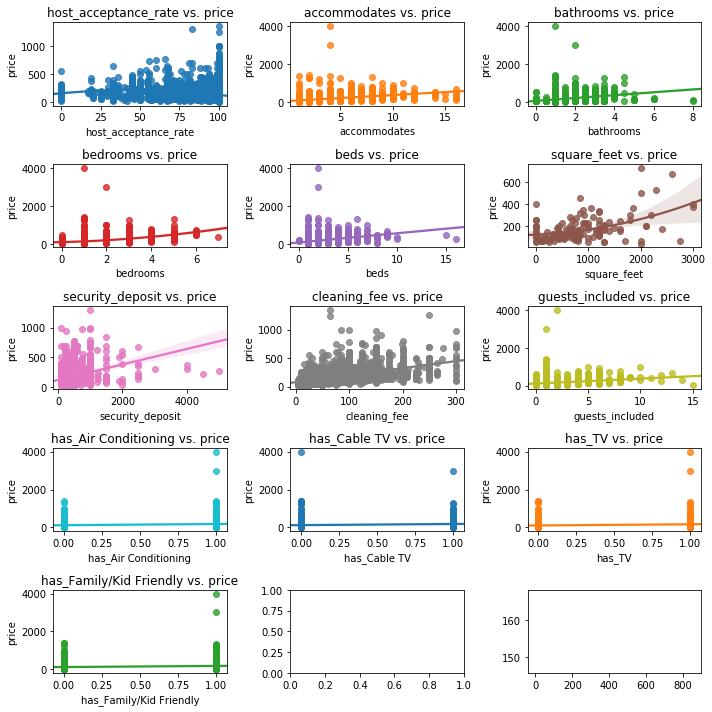

In [11]:
# Visualize interesting correlations
num_visual(corr_dict,full_df_all_num,'price',threshold=0.2,filename='num_corr')

In [12]:
# Select numerical features for regression_df
reg_df = full_df_all_features_norm.loc[:,
                                       [feature for feature in corr_dict.keys() if corr_dict[feature][1]>=0.2]+['price']]

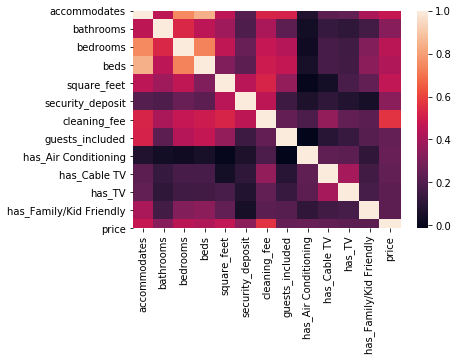

In [13]:
# Check reg_df for multicollinearity
sns.heatmap(reg_df.corr())
plt.savefig('corr_mat')

In [14]:
# Drop beds and bedrooms as they are reflected in accomodates
reg_df.drop(['beds','bedrooms'],axis=1,inplace=True)

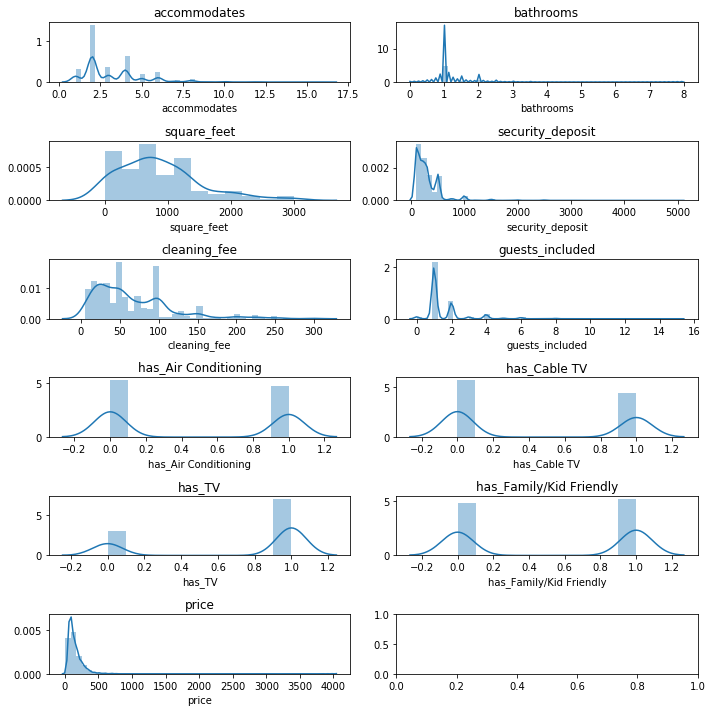

In [15]:
# Visualize distribution of selected numerical features
dist_visualizer(reg_df,filename='dist_pre')

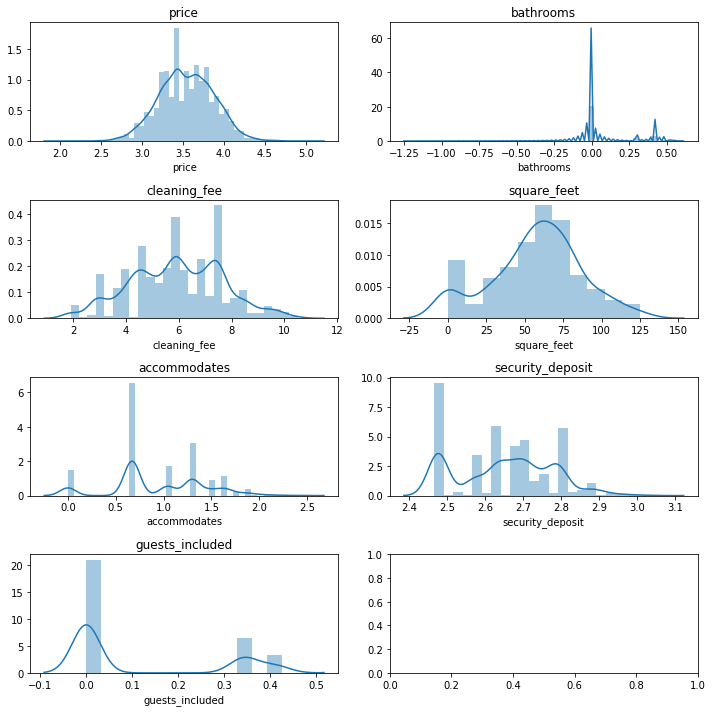

In [16]:
# Adjust distributions of selected numerical features
reg_df = adjust_distribution(reg_df,['price','bathrooms','cleaning_fee','square_feet','accommodates','security_deposit',
                                     'guests_included'],filename='dist_aft')

In [38]:
# Show descriptives of included non-binary features
reg_df.loc[:,['price','bathrooms','cleaning_fee','square_feet','accommodates','security_deposit','guests_included']] \
      .describe()

,price,bathrooms,cleaning_fee,square_feet,accommodates,security_deposit,guests_included
count,7403.000000,7373.000000,5266.000000,153.000000,7403.000000,3208.000000,7403.000000
mean,3.546941,0.087010,5.927812,57.565385,0.951067,2.651220,0.115414
std,0.329042,0.200453,1.742554,29.142804,0.492224,0.125522,0.170679
min,1.986097,-1.251542,1.892196,0.000000,0.000000,2.466170,0.000000
25%,3.321948,0.000000,4.486091,43.325206,0.670194,2.572701,0.000000
50%,3.550659,0.000000,5.881271,60.239837,0.670194,2.676293,0.000000
75%,3.787951,0.000000,7.353607,76.510390,1.296498,2.758109,0.342267
max,5.045031,0.614357,10.502208,124.852542,2.428744,3.043671,0.425209


##### Comment on scaling
From the above table, it becomes apparent, that especially guests_included, bathrooms, and square_feet have a noteably different scaling from the other features, which suggests, that feature_scaling might be helpful.

In [17]:
# Select categorical features
df_cat = full_df_all_features_norm.loc[
    :,
    [col for col in full_df_all_features_norm.columns if full_df_all_features_norm[col].dtype == 'object' or col == 'price']
]
obj_dict = obj_selector(df_cat,target='price',max_cats=25)
obj_dict

{'host_response_time': (0.05344491533339858, 0.09481755738384047),
 'host_is_superhost': (0.010848153697488504, 0.01474057160560385),
 'host_has_profile_pic': (0.005756323830407542, 0.007376044478613897),
 'host_identity_verified': (0.007507472108080292, 0.009712258084998388),
 'neighbourhood_group_cleansed': (0.04619469876017409, 0.18517212113296225),
 'state': (nan, 0.18517212113296225),
 'market': (0.06725544859956342, 0.1851721211329622),
 'is_location_exact': (nan, 0.036645057905595906),
 'property_type': (0.02312015554934491, 0.09761933620138603),
 'room_type': (nan, 0.4028227711589099),
 'bed_type': (nan, 0.1146528656088858),
 'instant_bookable': (nan, 0.04267376778414579),
 'cancellation_policy': (nan, 0.1511418644598715),
 'require_guest_profile_picture': (nan, 0.002607212476649295),
 'require_guest_phone_verification': (nan, 0.08307848933771513)}

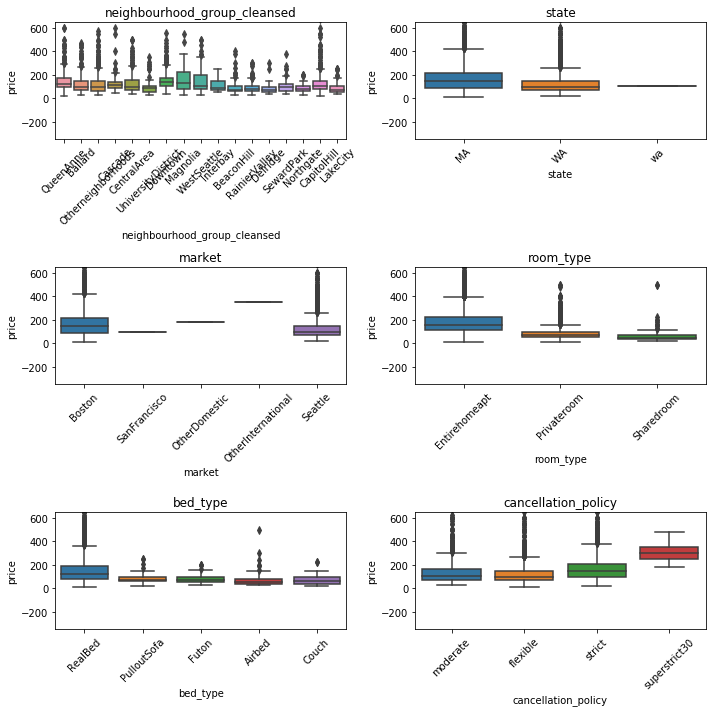

In [18]:
# Visualize correlation of objects
obj_visualizer(obj_dict,df=full_df_all_features_norm,target='price',threshold=0.1,filename='cat_corr')

In [19]:
# Append selected features to reg_df
reg_df = pd.concat(
    [reg_df,full_df_all_features_norm.loc[
        :,
        [feature for feature in obj_dict.keys() if obj_dict[feature][1]>0.1]
    ]
    ],
sort=False,axis=1).reset_index().drop('index',axis = 1)

In [20]:
# Create dummys for dataframe
reg_df = pd.get_dummies(reg_df,dummy_na=True,drop_first=True)

In [21]:
# Adjust faulty observations
reg_df.loc[reg_df['state_wa']==1,'state_WA'] = 1
reg_df.drop('state_wa',axis=1,inplace=True)
reg_df.drop(['market_SanFrancisco','market_OtherDomestic','market_OtherInternational'],axis=1,inplace=True)

In [22]:
# Split datframe in features and target
features_raw = reg_df.loc[:,[feature for feature in reg_df.columns if feature != 'price']]
target = reg_df.loc[:,['price']]

In [23]:
# Fill nan value with experimental iterative imputer
imputer = IterativeImputer(estimator=GradientBoostingRegressor())
features = imputer.fit_transform(features_raw)

features = pd.DataFrame(features,columns=[name for name in features_raw.columns])

C:\Users\Marco\Anaconda3\envs\blogpost\lib\site-packages\sklearn\impute\_iterative.py:599: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


In [24]:
# Create final df
final_df = pd.concat([features,target],sort=False,axis=1).reset_index().drop('index',axis=1)

In [25]:
# Check final df
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7403 entries, 0 to 7402
Data columns (total 44 columns):
accommodates                                       7403 non-null float64
bathrooms                                          7403 non-null float64
square_feet                                        7403 non-null float64
security_deposit                                   7403 non-null float64
cleaning_fee                                       7403 non-null float64
guests_included                                    7403 non-null float64
has_Air Conditioning                               7403 non-null float64
has_Cable TV                                       7403 non-null float64
has_TV                                             7403 non-null float64
has_Family/Kid Friendly                            7403 non-null float64
neighbourhood_group_cleansed_BeaconHill            7403 non-null float64
neighbourhood_group_cleansed_CapitolHill           7403 non-null float64
neighbourhood_gro

In [26]:
# Save final_df for modelling
final_df.to_csv('price_determinats_ml_rdy.csv',index=False)